In [1]:

import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from google.colab import drive
import zipfile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
driver_details = pd.read_csv('/content/gdrive/My Drive/kaggle_dataset/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [5]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/content/gdrive/My Drive/kaggle_dataset/imgs/train/c"+str(i))

    k = 0
    for j in range(len(imgs)):
    # for j in range(100):
        k+=1
        if(k % 100 == 0):
          print(k)
        img_name = "/content/gdrive/My Drive/kaggle_dataset/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

now we are in the folder C 0
now we are in the folder C 0
100
100
200
200
300
300
400
400
500
500
600
600
700
700
800
800
900
900
1000
1000
1100
1100
1200
1200
1300
1300
1400
1400
1500
1500
1600
1600
1700
1700
1800
1800
1900
1900
2000
2000
2100
2100
2200
2200
2300
2300
2400
2400
now we are in the folder C 1
now we are in the folder C 1
100
100
200
200
300
300
400
400
500
500
600
600
700
700
800
800
900
900
1000
1000
1100
1100
1200
1200
1300
1300
1400
1400
1500
1500
1600
1600
1700
1700
1800
1800
1900
1900
2000
2000
2100
2100
2200
2200
now we are in the folder C 2
now we are in the folder C 2
100
100
200
200
300
300
400
400
500
500
600
600
700
700
800
800
900
900
1000
1000
1100
1100
1200
1200
1300
1300
1400
1400
1500
1500
1600
1600
1700
1700
1800
1800
1900
1900
2000
2000
2100
2100
2200
2200
2300
2300
now we are in the folder C 3
now we are in the folder C 3
100
100
200
200
300
300
400
400
500
500
600
600
700
700
800
800
900
900
1100
1100
1200
1200
1300
1300
1400
1400
1500
1500
1600
1600


In [0]:

## Randomly shuffling the images

import random
random.shuffle(train_image)

In [0]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [15]:
X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))


18732 3692
18732 3692


In [16]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)

(18732, 224, 224, 3)


In [17]:
## Defining the input

from keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')


## The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
#Use the generated model 
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(input = vgg16_input, output = x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/25
293/292 [==============================] - 554s 2s/step - loss: 2.3836 - accuracy: 0.1142 - val_loss: 2.2971 - val_accuracy: 0.1306

Epoch 00001: val_loss improved from inf to 2.29714, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 2/25
293/292 [==============================] - 524s 2s/step - loss: 2.2739 - accuracy: 0.1410 - val_loss: 2.2266 - val_accuracy: 0.2481

Epoch 00002: val_loss improved from 2.29714 to 2.22662, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 3/25
293/292 [==============================] - 525s 2s/step - loss: 2.2038 - accuracy: 0.1841 - val_loss: 2.2773 - val_accuracy: 0.1763

Epoch 00003: val_loss did not improve from 2.22662
Epoch 4/25
293/292 [==============================] - 524s 2s/step - loss: 2.0086 - accuracy: 0.2489 - val_loss: 1.6264 - val_accuracy: 0.3586

Epoch 00004: val_loss improved from 2.22662 to 1.62640, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 5/25
293/292 [==============================] - 524s 2s/ste

In [0]:
vgg16_pretrained.save('vgg16_tl.h5')
#vgg16_model.save_model("vgg16_tl.h5")
!cp  vgg16_tl.h5   /content/gdrive/My\ Drive/kaggle_dataset/

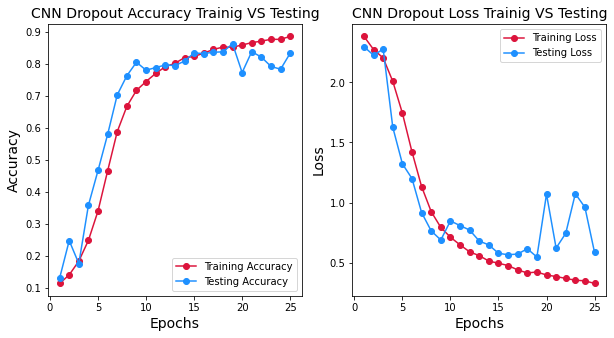

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy']) + 1), vgg16_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy']) + 1), vgg16_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


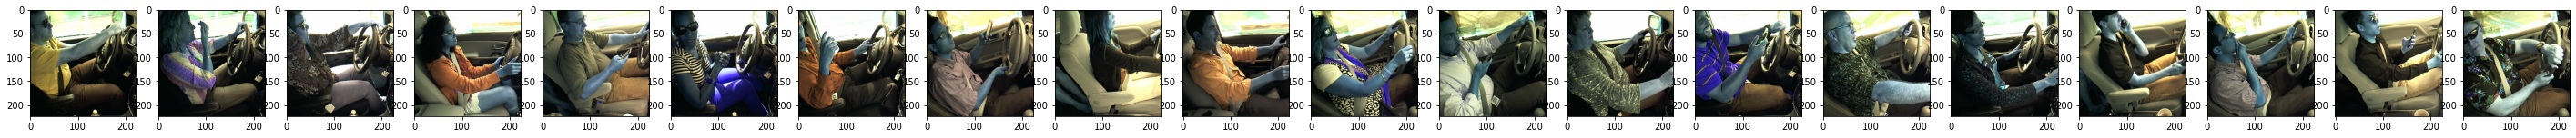

In [29]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('/content/gdrive/My Drive/kaggle_dataset/imgs/test/')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('/content/gdrive/My Drive/kaggle_dataset/imgs/test/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show

In [0]:
test = []

for img in test_image:
    test.append(img)
    
vgg16_pretrained.load_weights('vgg_weights_aug_setval_sgd.hdf5')


test = np.array(test).reshape(-1,224,224,3)
prediction = vgg16_pretrained.predict(test)

In [0]:

tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

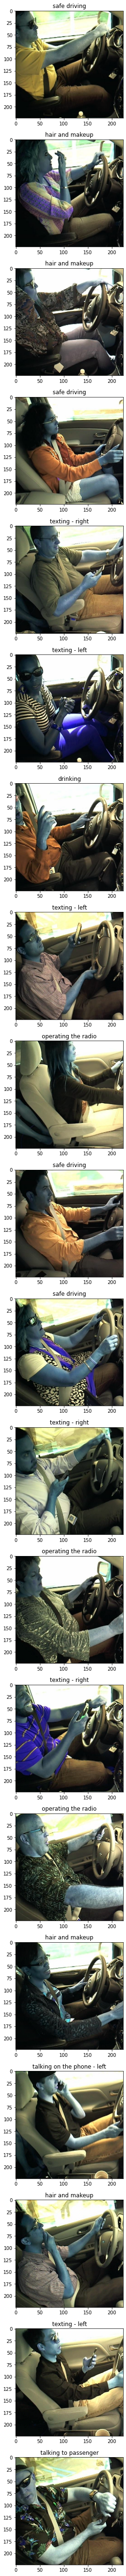

In [32]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show